In [1]:
import numpy as np
import os
import glob
import shutil
import zipfile
from pathlib import Path
import tensorflow as tf
from keras import backend as K
from keras.utils import np_utils, to_categorical
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [18]:
class sign_lang(object):
    
    # global variable initializer
    IMAGE_SIZE = 100
    NUM_CLASS = 29
    BATCH_SIZE = 32
    EPOCHS = 30
    target_size = (IMAGE_SIZE, IMAGE_SIZE)
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    cwd = os.getcwd()
    
    def __init__(self, filename):
        self.filename = filename
        
    def get_dir(self, filename=''):
        return self.cwd + '/' + filename
    
    def unzip(self, path):
        filename = path.split('/')[-1]
        folder = str(Path(path).parent) + '/' + filename.split('.')[0]
        if not os.path.exists(folder):
            print('Unzip file...')
            zfile = zipfile.ZipFile(path, 'r')
            zfile.extractall(folder)
            zfile.close()
            print('Files unzipped to folder: {0}'.format(folder))
        return folder
        
    def make_dir(self, path):
        if not os.path.exists(path):
            os.mkdir(path)
        return path
            
    def move_files(self, files, path):
        for file in files:
            if not os.path.isfile(path + '/' + file.split('/')[-1]):
                shutil.move(file, path)
    
    def prepare_data(self):
        zipfile = self.get_dir(self.filename)
        self.unzip(zipfile)
        zipdir = self.get_dir(self.filename.split('.')[0])
        zipfiles = glob.glob(zipdir + '/*.zip')
        folders = []
        for file in zipfiles:
            folder = self.unzip(file)
            folders.append(folder)
        return folders
    
    def train_val_data(self):
        folders = self.prepare_data()
        train_folder = folders[0] + '/' + folders[0].split('/')[-1]
        train_subdir = glob.glob(train_folder + '/*')
        train_subdir.sort()
        val_folder = self.make_dir(str(Path(train_folder).parent) + '/asl_alphabet_val')
        print('Moving images from training set to validation set...')
        for d in train_subdir:
            val_subdir = str(Path(d).parent.parent) + '/asl_alphabet_val/' + d.split('/')[-1]
            self.make_dir(val_subdir)
            images = glob.glob(d + '/*.jpg')
            images.sort()
            images_val = images[int(-0.3*len(images))-1:]
            if len(os.listdir(val_subdir)) == 0:
                self.move_files(images_val, val_subdir)
                print('{0} images moved for category {1}'.format(len(images_val), d.split('/')[-1]))
        print('Moving Complete!')
        return train_folder, val_folder
            
    def test_images(self):
        folders = self.prepare_data()
        test_folder = folders[1] + '/' + folders[1].split('/')[-1]
        test_images = glob.glob(test_folder + '/*.jpg')
        test_images.sort()
        return test_images
    
    def data_generator(self):
        train_datagen = ImageDataGenerator(
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           rotation_range=15,
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,
                                           rescale = 1/255
                                            )
        val_datagen = ImageDataGenerator(rescale = 1/255)
        
        train_folder, val_folder = self.train_val_data()
        train_generator = train_datagen.flow_from_directory(train_folder,
                                                            target_size = self.target_size,
                                                            batch_size = self.BATCH_SIZE)
        val_generator = val_datagen.flow_from_directory(val_folder,
                                                        target_size = self.target_size,
                                                        batch_size = self.BATCH_SIZE,
                                                       )
        return train_generator, val_generator
    
    def run_model(self, model_name):
        train_generator, val_generator = self.data_generator()
        earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
        mcp_save = ModelCheckpoint('sign_lang.h5', save_best_only=True, monitor='val_loss', mode='min')
        callbacks = [earlyStopping, mcp_save]
        model = self.build_model(self.input_shape, self.NUM_CLASS, self.BATCH_SIZE, self.EPOCHS)
        model.fit_generator(train_generator,
                            steps_per_epoch=len(train_generator.filenames) // self.BATCH_SIZE,
                            epochs=self.EPOCHS,
                            callbacks=callbacks,
                            validation_data=val_generator,
                            validation_steps=len(val_generator.filenames) // self.BATCH_SIZE,
                            verbose=1)
        model_dir = self.get_dir('models/')
        self.make_dir(model_dir)
        model.save(model_dir + model_name)
    
    def build_model(self, input_shape, num_class, batch_size, epochs):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(units=128, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(units=num_class, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
        return model
    
    def train(self, model_name): 
        if os.path.isfile(self.get_dir('models') + '/' + model_name):
            val = input('Model Exists. Run and overwrite the existed model(Y/N)?')
            if val.lower() == 'y':
                self.run_model(model_name)
            elif val.lower() == 'n':
                print('Keep Existed Model')
        else:
            self.run_model(model_name)
    
    def plot_images(self):
        test_images = self.test_images()
        fig = plt.subplots(figsize=(18,6))
        for i, img in enumerate(test_images):
            plt.subplot(3,10,i+1)
            plt.imshow(plt.imread(img))
            plt.xticks([])
            plt.yticks([])
            plt.title(img.split('/')[-1].split('.')[0].split('_')[0])
        plt.tight_layout(pad=0, h_pad=0, w_pad=0)
        plt.show()
        
    def evaluate(self, model_name):
        model_dir = self.get_dir('models/')
        model = load_model(model_dir + model_name)
        _, val_generator = self.data_generator()
        STEP_SIZE_VAL = val_generator.n // val_generator.batch_size
        _, acc = model.evaluate_generator(val_generator, steps=STEP_SIZE_VAL, verbose=0)
        print('Model Accuracy: {0:.1f}%'.format(acc * 100))

    def predict(self, image):
        img = load_img(image, target_size=self.target_size)
        img_data = img_to_array(img).reshape(1, self.IMAGE_SIZE, self.IMAGE_SIZE, 3)
        model_name = 'sign_lang.h5'
        model_dir = self.get_dir('models/')
        model = load_model(model_dir + model_name)
        label = model.predict(img_data)
        test_images = self.test_images()
        label_list = [t.split('/')[-1].split('_')[0] for t in test_images]
        label = label_list[np.argmax(label)]
        return label

In [3]:
file_name = 'asl-alphabet.zip'
modelname = 'sign_lang.h5'

In [19]:
slc = sign_lang(file_name)

In [5]:
slc.train(modelname)

Unzip file...
Files unzipped to folder: /Users/rong/Documents/github/asl-alphabet/asl-alphabet
Unzip file...
Files unzipped to folder: /Users/rong/Documents/github/asl-alphabet/asl-alphabet/asl_alphabet_train
Unzip file...
Files unzipped to folder: /Users/rong/Documents/github/asl-alphabet/asl-alphabet/asl_alphabet_test
Moving images from training set to validation set...
901 images moved for category A
901 images moved for category B
901 images moved for category C
901 images moved for category D
901 images moved for category E
901 images moved for category F
901 images moved for category G
901 images moved for category H
901 images moved for category I
901 images moved for category J
901 images moved for category K
901 images moved for category L
901 images moved for category M
901 images moved for category N
901 images moved for category O
901 images moved for category P
901 images moved for category Q
901 images moved for category R
901 images moved for category S
901 images moved 

In [8]:
slc.evaluate(modelname)

Moving images from training set to validation set...
Moving Complete!
Found 60871 images belonging to 29 classes.
Found 26296 images belonging to 29 classes.
Model Accuracy: 88.8%


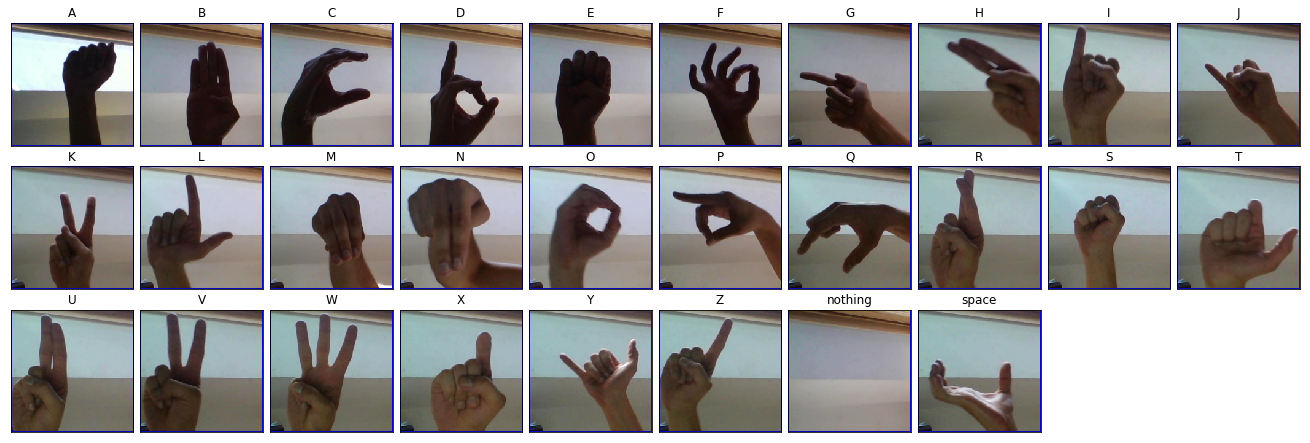

In [9]:
slc.plot_images()